
# 🌍 Climate Data Workflow: Intake-ESM + ESGF + Rook (with Timing)

This notebook demonstrates how to build a **remote climate data analysis workflow** using:
- **[Intake-ESM](https://intake-esm.readthedocs.io/)** → search/filter CMIP6 catalogs  
- **[pyesgf](https://esgf-pyclient.readthedocs.io/)** → get ESGF-compatible dataset identifiers  
- **[Rook](https://rook.readthedocs.io/)** → perform subset and averaging operations remotely  
- **[xarray](http://xarray.pydata.org/)** → open, manipulate, and visualize NetCDF results  

We also measure execution time of each step to understand performance.


In [1]:

import os
import time
import intake
import xarray as xr
import matplotlib.pyplot as plt
from pyesgf.search import SearchConnection
from rooki import operators as ops

# Configure Rook service endpoint
os.environ["ROOK_URL"] = "http://rook.dkrz.de/wps"
os.environ["ROOK_MODE"] = "async"

# Store timings in a dictionary for later plotting
timings = {}



## 🔍 Step 1: Search with Intake-ESM

We start by connecting to the CMIP6 catalog published at DKRZ via Intake-ESM.  
We filter for one dataset (EC-Earth3, ScenarioMIP, variable `tas`).  
This helps us explore available datasets without downloading files.


In [2]:

start = time.time()

cat_url = "https://gitlab.dkrz.de/data-infrastructure-services/intake-esm/-/raw/master/esm-collections/cloud-access/dkrz_cmip6_disk.json"
col = intake.open_esm_datastore(cat_url)

query = dict(
    activity_id="ScenarioMIP",
    institution_id="EC-Earth-Consortium",
    source_id="EC-Earth3",
    experiment_id="ssp585",
    table_id="day",
    variable_id="tas",
    grid_label="gr",
)

cat = col.search(**query)

print(f"Found {len(cat.df)} matching entries")
display(cat.df.head(1))

timings["Intake-ESM search"] = time.time() - start


Found 688 matching entries


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,dcpp_init_year,version,...,frequency,time_reduction,long_name,units,realm,level_type,time_min,time_max,format,uri
0,ScenarioMIP,EC-Earth-Consortium,EC-Earth3,ssp585,r11i1p1f1,day,tas,gr,<NA>,v20200201,...,day,mean,Near-Surface Air Temperature,K,atmos,<NA>,20150101,20151231,netcdf,/work/ik1017/CMIP6/data/CMIP6/ScenarioMIP/EC-E...



## 🔎 Step 2: Search with ESGF

Intake-ESM gives us metadata, but Rook requires an **ESGF dataset identifier**.  
We use the ESGF Python client (`pyesgf`) to query the DKRZ node and get a valid `instance_id`.


In [3]:

start = time.time()

conn = SearchConnection("https://esgf-data.dkrz.de/esg-search", distrib=False)
ctx = conn.new_context(project="CMIP6", latest=True, replica=True, data_node="esgf3.dkrz.de")

results = ctx.search(
    source_id="EC-Earth3",
    experiment_id="ssp585",
    variable="tas",
    table_id="day",
    institution_id="EC-Earth-Consortium",
    variant_label="r1i1p1f1"
)

ds = results[0]
dataset_id = ds.json["instance_id"]
print("✅ dataset_id:", dataset_id)

timings["ESGF search"] = time.time() - start


✅ dataset_id: CMIP6.ScenarioMIP.EC-Earth-Consortium.EC-Earth3.ssp585.r1i1p1f1.day.tas.gr.v20200310



## 🏗️ Step 3: Rook Subset + Average

We now send a request to **Rook** to:
1. Subset the dataset over a specific region (Europe-like bounding box).  
2. Subset the dataset over a time range (2016–2031).  
3. Average the results over the time dimension.  

Rook will return a processed NetCDF file as output.


In [4]:

start = time.time()

bbox = "-1,41,15,51"
tas = ops.Input("tas", [dataset_id])
sub = ops.Subset(tas, time="2016-01-01/2031-12-31", area=bbox)
avg = ops.Average(sub, dims="time")

resp = avg.orchestrate()
assert resp.ok, "Rook processing failed!"

print("📦 Metalink URL:", resp.url)
print("📥 File URL:", resp.download_urls()[0])

timings["Rook processing"] = time.time() - start


📦 Metalink URL: http://rook7.cloud.dkrz.de:80/outputs/rook/b999ce68-baf5-11f0-aaeb-fa163eb671ca/input.meta4
📥 File URL: http://rook7.cloud.dkrz.de:80/outputs/rook/238cbe0c-baf6-11f0-a84c-fa163eb671ca/tas_day_EC-Earth3_ssp585_r1i1p1f1_gr_avg-t.nc



## 📊 Step 4: Download and Load Results

We download the processed NetCDF file from Rook, open it with **xarray**,  
and plot the average near-surface air temperature field.


<xarray.Dataset> Size: 2kB
Dimensions:   (lat: 15, bnds: 2, lon: 23)
Coordinates:
  * lat       (lat) float64 120B 41.05 41.75 42.46 43.16 ... 49.47 50.18 50.88
  * lon       (lon) float64 184B -0.7031 0.0 0.7031 1.406 ... 13.36 14.06 14.77
    height    float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 240B ...
    lon_bnds  (lon, bnds) float64 368B ...
    tas       (lat, lon) float32 1kB ...
Attributes: (12/47)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time:            0.0
    comment:                Production: Thomas Reerink at KNMI
    contact:                cmip6-data@ec-earth.org
    ...                     ...
    license:                CMIP6 model data produced by EC-Earth-Consortium ...
    cmor_version:           3.5.0
    tracking_id:            hdl:21.14100/1ad61af9-9d15-4149-bd21-5e50937af231
    branch_time_in_child:   60265.0D
    branch_time_in_parent:  60265.0D
    history:                2019-09-27T17:11:09Z ; CMOR rewrote data to be co...

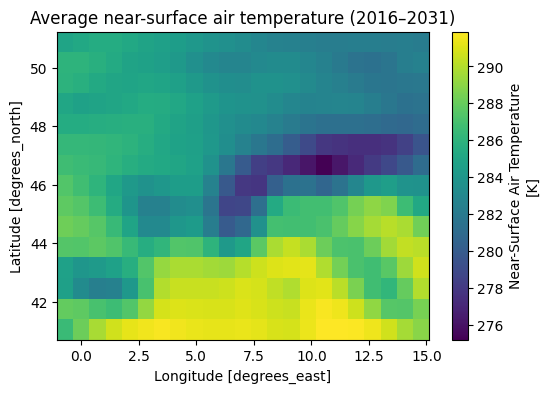

In [5]:

start = time.time()

ds_out = resp.datasets()[0]
display(ds_out)

timings["Download + load"] = time.time() - start

# Plot result
plt.figure(figsize=(6, 4))
ds_out.tas.plot()
plt.title("Average near-surface air temperature (2016–2031)")
plt.show()



## 📝 Step 5: Provenance

Rook provides provenance information in PROV format, which helps  
track how the dataset was processed.  
We can display the provenance URL and the provenance diagram.


📄 Provenance JSON URL: http://rook7.cloud.dkrz.de:80/outputs/rook/b999ce68-baf5-11f0-aaeb-fa163eb671ca/provenance.json


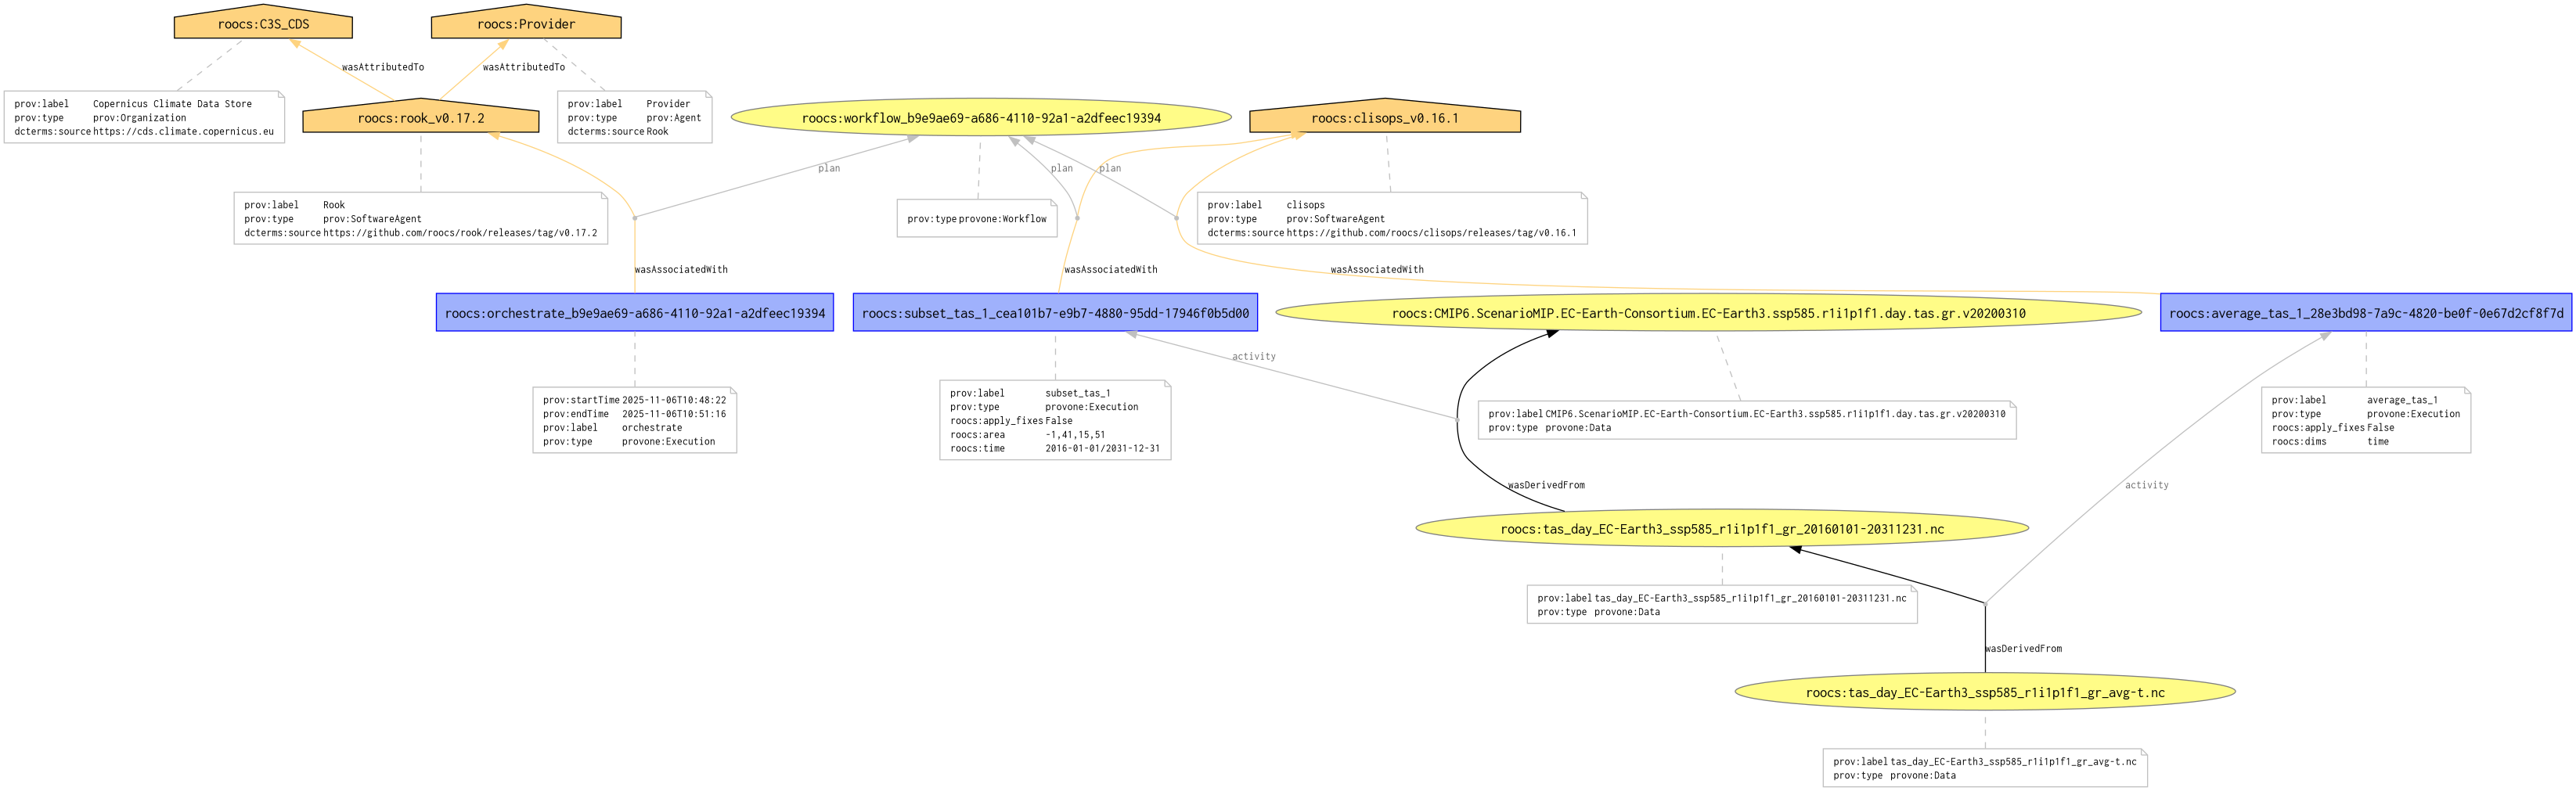

In [18]:

# Get provenance WITHOUT timing
prov_url = resp.provenance()
print("📄 Provenance JSON URL:", prov_url)
Image(resp.provenance_image())



## ⏱️ Step 6: Timing Analysis

Finally, let’s visualize how much time each step took.  
This helps identify bottlenecks (e.g. network requests or Rook processing).


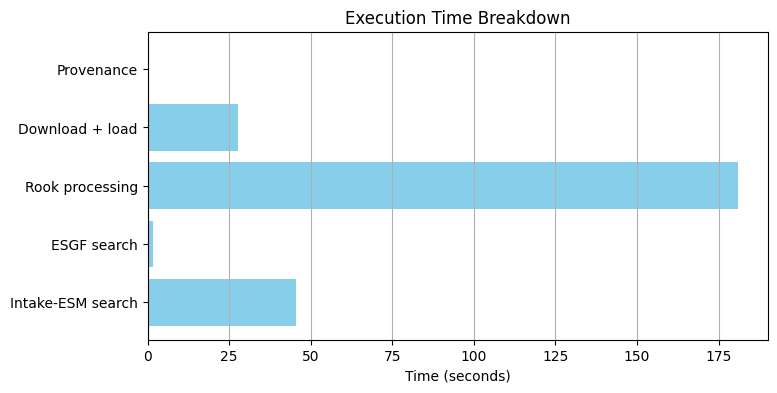

Intake-ESM search   : 45.45 seconds
ESGF search         : 1.71 seconds
Rook processing     : 180.99 seconds
Download + load     : 27.68 seconds
Provenance          : 0.00 seconds


In [19]:

# Plot timings
plt.figure(figsize=(8, 4))
plt.barh(list(timings.keys()), list(timings.values()), color='skyblue')
plt.xlabel("Time (seconds)")
plt.title("Execution Time Breakdown")
plt.grid(True, axis='x')
plt.show()

# Print raw timings
for step, t in timings.items():
    print(f"{step:20s}: {t:.2f} seconds")
